# Random Forest

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import torch
import matplotlib.pyplot as plt
import random
from sklearn import model_selection
import torch.nn.functional as F

# Load the dataset
df = pd.read_csv('28-06-removed-data-cleaning.csv')  # Replace "your_dataset.csv" with the actual path to your dataset
df.shape

(5565, 12)

In [2]:
agzone_map = {
    "NSW VH3": 0,
    "NSW H1": 1,
    "NSW H2": 2,
    "NSW H3": 3,
    "VIC H1": 4,
    "VIC H2": 5,
    "WA H1": 6,
    "WA H2": 7,
    "WA H3": 8,
    "WA H4": 9,
    "WA H5": 10,
    "WA H5W": 11,
    "WA M1": 12,
    "WA M2": 13,
    "WA M3": 14,
    "WA M4": 15,
    "WA M5": 16,
    "NSW M2": 17,
    "NSW M3": 18,
    "VIC M1": 19,
    "VIC M2": 20,
    "WA L1": 21,
    "WA L2": 22,
    "WA L3": 23,
    "WA L4": 24,
    "WA L5": 25,
    "NSW L3": 26,
}

name_map = {
    "ChickpeaKabul": 0,
    "AdzukiBean": 1,
    "Lupin": 2,
    "Lucerne": 3,
    "Silage": 4,
    "FabaBean": 5,
    "OtherHay": 6,
    "Vetch": 7,
    "OatenHay": 8,
    "Triticale": 9,
    "CerealRye": 10,
    "FeedBarley": 11,
    "Wheat": 12,
    "OtherCrop": 13,
    "Oat": 14,
    "MaltBarley": 15,
    "Lentil": 16,
    "Canola": 17,
    "AlbusLupin": 18,
    "Sunflower": 19,
    "CanolaGm": 20,
    "Rice": 21,
    "Sorghum": 22,
    "MaizeOrCorn": 23,
    "ChickpeaDesi": 24,
    "FieldPea": 25,
    "Cotton": 26
}

df["Agzone"] = df["Agzone"].map(agzone_map).astype(int)
df["Name"] = df["Name"].map(name_map).astype(int)

df.shape

(5565, 12)

In [23]:
# group data
number_of_years = 4
grouped_df = df.groupby(['ProfitSeriesBusinessId', 'Name'])
filtered_df = grouped_df.filter(lambda group_data: (~group_data['Year'].duplicated()).all() and len(group_data['Year']) >= number_of_years)

sorted_df = filtered_df.groupby('ProfitSeriesBusinessId').apply(lambda x: x.sort_values('Year'))
sorted_df = sorted_df.reset_index(drop=True)

# Convert each group to a list of dictionaries
grouped_list = [group.to_dict(orient='records') for _, group in sorted_df.groupby(['ProfitSeriesBusinessId','Name'])]

# Group
combinations = []
for group in grouped_list:
    [combinations.append(group[i:i+number_of_years]) for i in range(len(group)-(number_of_years-1))]

In [4]:
# map each data vector

excluded_keys = ['Name', 'ProfitSeriesBusinessId', 'Id', 'Agzone', 'Year']

regression_data = []
name_data = []
agzone_data = []
targets = []
for combination in combinations:
    combined_dict = {}
    for row in combination:
        filtered_row = {key: value for key, value in row.items() if key not in excluded_keys}
        for key, value in filtered_row.items():
            combined_key = key + str(row['Year'])
            combined_dict[combined_key] = value

    current_year = max(combination, key=lambda x: x['Year'])['Year']
    
    targets.append(combined_dict[f"YieldTonnesPerHa{current_year}"])
    del combined_dict[f"YieldTonnesPerHa{current_year}"]
    del combined_dict[f"WUE_KgPerHa{current_year}"]
    
    regression_data.append(combined_dict)
    name_data.append(combination[0]['Name'])
    agzone_data.append(combination[0]['Agzone'])
    

In [5]:
# convert data to lists
X_regression = []

for dictionary in regression_data:
    values = list(dictionary.values())
    X_regression.append(values)

In [6]:
def create_one_hot_layer(features, num_classes):
    return F.one_hot(features, num_classes)

one_hot_agzone = create_one_hot_layer(features=torch.tensor(agzone_data), num_classes=27)
one_hot_name = create_one_hot_layer(features=torch.tensor(name_data), num_classes=27)

X_regression = np.concatenate((X_regression, one_hot_agzone, one_hot_name), axis=1)

In [7]:
# Splitting regression features
X_train_regression, X_test_regression, y_train, y_test = model_selection.train_test_split(
    X_regression, targets, test_size=0.2, random_state=42)

In [8]:
print("Train set: ", len(X_train_regression))

print("Test set: ", len(X_test_regression))


Train set:  284
Test set:  72


In [9]:
def mean_absolute_error(y_test, y_pred, n_estimators, max_depth):
    # Convert tensors to numpy arrays
    prediction = np.array(y_pred)
    y_test = np.array(y_test)

    # Calculate the absolute differences between predictions and true values
    abs_diff = np.abs(prediction - y_test)

    # Calculate the mean absolute error
    mae = np.mean(abs_diff)

    print("MAE for n_estimators={}, max_depth={}: {}".format(n_estimators, max_depth, mae))
    return mae


In [10]:
def mean_squared_error(y_test, y_pred, n_estimators, max_depth):
    # Convert tensors to numpy arrays
    prediction = np.array(y_pred)
    y_test = np.array(y_test)

    # Calculate the squared differences between predictions and true values
    squared_diff = np.square(prediction - y_test)

    # Calculate the mean squared error
    mse = np.mean(squared_diff)

    print("MSE for n_estimators={}, max_depth={}: {}".format(n_estimators, max_depth, mse))
    return mse

In [16]:
# Define the hyperparameter ranges
# n_estimators_range = [80, 90, 100, 110, 120, 1950, 2000, 2050, 2500]
# n_estimators_range = [75, 80, 85, 90]
n_estimators_range = [80]
# max_depth_range = [5, 10, 20, 30, 40, 80, 120, 160]
# max_depth_range = [8, 9, 10, 11, 12]
max_depth_range = [9]

# Iterate over hyperparameter combinations
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        # Create a Random Forest regressor
        rf_regressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=2, random_state=42)
        
        # Train the regressor
        rf_regressor.fit(X_train_regression, y_train)
        
        # Make predictions on the test set
        y_pred = rf_regressor.predict(X_test_regression)
        
        # Evaluate the model
        mae = mean_absolute_error(y_test, y_pred, n_estimators, max_depth)
        mse = mean_squared_error(y_test, y_pred, n_estimators, max_depth)

MAE for n_estimators=80, max_depth=9: 0.4587045977336744
MSE for n_estimators=80, max_depth=9: 0.4263820208957831


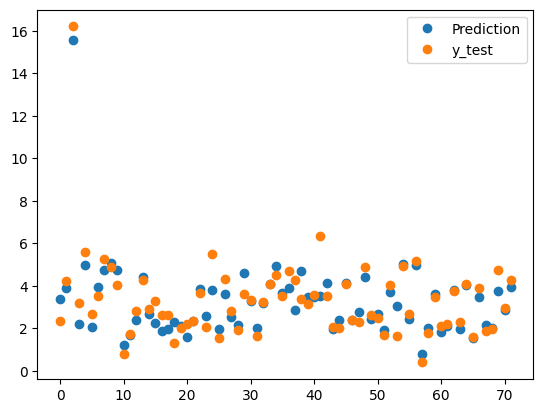

In [26]:
# Forward pass on test data
prediction = y_pred.tolist()


plt.plot(prediction, 'o', label='Prediction')
plt.plot(y_test, 'o', label='y_test')

plt.legend()
plt.show()

In [21]:
user_input = random.randint(0,len(X_test_regression))

# Make predictions on the test set
prediction_of_user_data = rf_regressor.predict([X_test_regression[user_input]])
print('Prediction: ', prediction_of_user_data[0])
print('Target: ',y_test[user_input])

Prediction:  2.790504092573463
Target:  2.311472


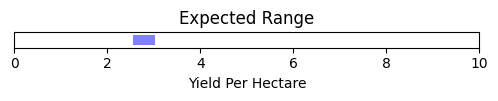

In [22]:
# Assuming you have the predicted value and range
predicted_value = prediction_of_user_data[0]
range_value = mae

# Set the figure size
fig, ax = plt.subplots(figsize=(6, 0.2))

# Create the horizontal bar chart
ax.barh(0, range_value, left=predicted_value - range_value/2, height=0.60, align='center', color='blue', alpha=0.5)

# Set the plot limits and labels
ax.set_xlim(0, 10)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Yield Per Hectare')
ax.set_title('Expected Range')

# Remove y-axis
ax.set_yticks([])

# Display the plot
plt.show()